In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']
from datetime import datetime

In [3]:
offline = pd.read_csv('practice_data/ccf_offline_stage1_train.csv', parse_dates=['Date_received','Date'])
offline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   User_id        int64         
 1   Merchant_id    int64         
 2   Coupon_id      float64       
 3   Discount_rate  object        
 4   Distance       float64       
 5   Date_received  datetime64[ns]
 6   Date           datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 93.7+ MB


## 数据的规整

### 2.1 把discount_rate中的满减政策转换成折扣率

In [6]:
offline['Discount_rate'] = offline['Discount_rate'].fillna('null')

In [7]:
def discount_rate_opt(s):
    if s == 'null':
        return np.NaN
    if ':' in s:
        split = s.split(':')
        discount_rate = (int(split[0]) - int(split[1])) / int(split[0]) 
        return round(discount_rate, 2)
    else:
        return float(s)

In [8]:
offline['Discount_rate'] = offline['Discount_rate'].map(discount_rate_opt)
offline.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17
1,1439408,4663,11002.0,0.87,1.0,2016-05-28,NaT
2,1439408,2632,8591.0,0.95,0.0,2016-02-17,NaT
3,1439408,2632,1078.0,0.95,0.0,2016-03-19,NaT
4,1439408,2632,8591.0,0.95,0.0,2016-06-13,NaT


## 2.2 Coupon_id字段：null代表无优惠卷，此时Discount_rate与Date_received字段无意义
检查Coupon_id和Discount_rate与Discount_received是否一一对应

In [10]:
nan1 = offline['Coupon_id'].isnull() #判断优惠卷是否为空
nan2 = offline['Date_received'].isnull()
np.all(nan1 == nan2) #如果结果为True，说明Coupon_id与Date_received空值与非空值一一对应

True

In [11]:
nan1 = offline['Coupon_id'].isnull() 
nan2 = offline['Discount_rate'].isnull()
np.all(nan1 == nan2)

True

## 2.3 消费情况分类
Date=null且Coupon_id!=null, 有优惠卷没消费 (cpon_no_consume)
Date=null且Coupon_id=null, 无优惠卷且没消费 (no_cpon_no_consume)
Date!=null且Coupon_id=null, 消费了但是没用优惠卷 (no_cpon_consume)
Date!=null且Coupon_id!=null, 有优惠卷且进行消费 (cpon_consume)

In [21]:
cpon_no_consume = offline[offline['Date'].isnull()&offline['Coupon_id'].notnull()]
no_cpon_no_consume = offline[offline['Date'].isnull()&offline['Coupon_id'].isnull()]
no_cpon_consume = offline[offline['Date'].notnull()&offline['Coupon_id'].isnull()]
cpon_consume = offline[offline['Date'].notnull()&offline['Coupon_id'].notnull()]

In [22]:
print('有券未消费:{}'.format(len(cpon_no_consume)))
print('无券未消费:{}'.format(len(no_cpon_no_consume)))
print('无券消费:{}'.format(len(np_cpon_consume)))
print('有券消费:{}'.format(len(cpon_consume)))

有券未消费:977900
无券未消费:0
无券消费:701602
有券消费:75382


## 数据分析

In [23]:
consume_state_dict = {'cpon_no_consume':len(cpon_no_consume), 'np_cpon_consume':len(np_cpon_consume), 'cpon_consume':len(cpon_consume)}
consume_status = pd.Series(consume_state_dict)

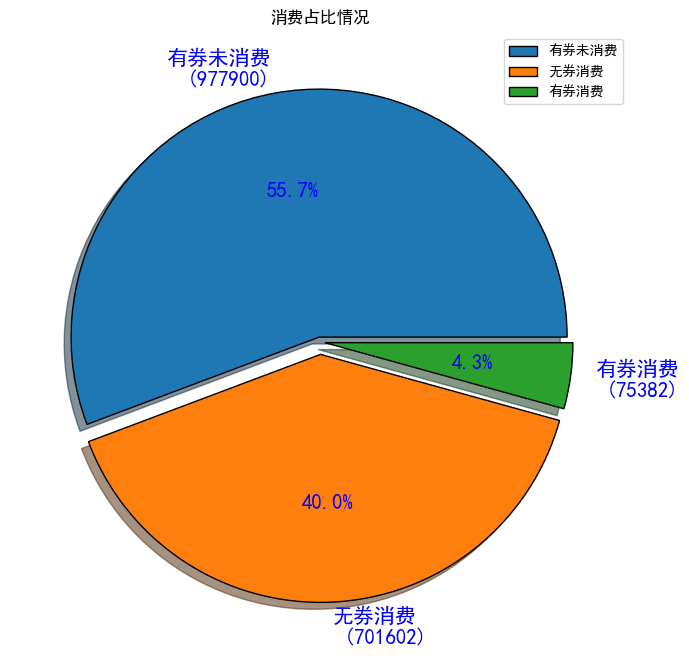

In [26]:
#消费方式构成的饼图
fig,ax=plt.subplots(1,1,figsize=(8,10))
consume_status.plot.pie(ax=ax, autopct='%1.1f%%', shadow=True, explode=[0.02,0.05,0.02],textprops={'fontsize':15, 'color':'blue'},
                       wedgeprops={'linewidth':1,'edgecolor':'black'},labels=['有券未消费\n ({})'.format(len(cpon_no_consume)),
                                                                              '无券消费\n ({})'.format(len(no_cpon_consume)),
                                                                             '有券消费\n ({})'.format(len(cpon_consume))])
ax.set_ylabel('') #去除ylabel
ax.set_title('消费占比情况')
plt.legend(labels=['有券未消费','无券消费','有券消费'])

## 3.1 在有券消费人群中，分析距离和优惠折扣力度

In [27]:
#各个商家对应的顾客到店平均距离
Merchant_distance = cpon_consume.groupby('Merchant_id')['Distance'].mean()
Merchant_distance

Merchant_id
3       0.000000
4       0.000000
5       1.000000
13      0.000000
14      0.000000
          ...   
8844    2.916667
8849    0.000000
8850    4.333333
8852         NaN
8856    0.000000
Name: Distance, Length: 4076, dtype: float64

<Axes: >

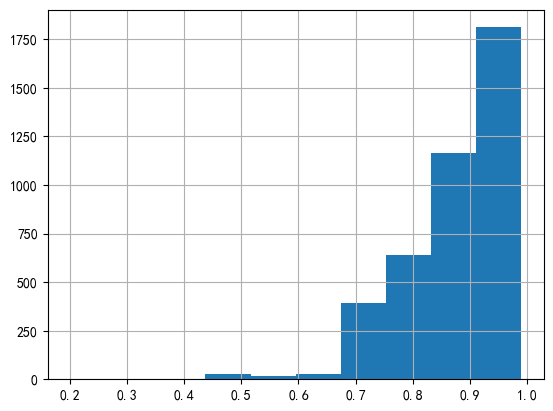

In [30]:
#各商家对应顾客到店消费平均折扣力度
Merchant_discount_rate = cpon_consume.groupby('Merchant_id')['Discount_rate'].mean()
Merchant_discount_rate.sort_values()
Merchant_discount_rate.hist()

## 3.2 持券到店消费人数最多的商家

In [33]:
popular_merchant = cpon_consume.groupby('Merchant_id')['User_id'].apply(lambda x: len(x.unique())).sort_values(ascending=False)
popular_merchant500 = popular_merchant[popular_merchant>500]
print('共有{}家店铺持券消费人数在500人以上'.format(len(popular_merchant500)))

共有16家店铺持券消费人数在500人以上


## 3.3 持券消费人数在500人以上商家，连接顾客到店平均距离和平均折扣力度

In [36]:
merchant_pop_dis = pd.merge(left=popular_merchant500, right=Merchant_distance, on='Merchant_id', how='inner')
merchant_pop_dis_rate = pd.merge(left=merchant_pop_dis, right=Merchant_discount_rate, on='Merchant_id',how='inner')
merchant_pop_dis_rate.rename(columns={'User_id':'customer_count'}, inplace=True)
merchant_pop_dis_rate

,customer_count,Distance,Discount_rate
Merchant_id,,,
5341,2800,0.168598,0.826036
760,2627,0.349866,0.799873
3381,2248,1.652429,0.744150
6485,2029,0.368567,0.770439
2099,1401,0.968072,0.900000
2934,1310,1.114833,0.830000
450,1094,0.892164,0.819274
3532,968,0.272498,0.852289
7555,925,1.329977,0.828381


In [37]:
merchant_pop_dis_rate.corr()

,customer_count,Distance,Discount_rate
customer_count,1.000000,-0.306180,-0.204102
Distance,-0.306180,1.000000,-0.397376
Discount_rate,-0.204102,-0.397376,1.000000


D:\conda\envs\myenv1\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<Axes: >

D:\conda\envs\myenv1\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
D:\conda\envs\myenv1\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


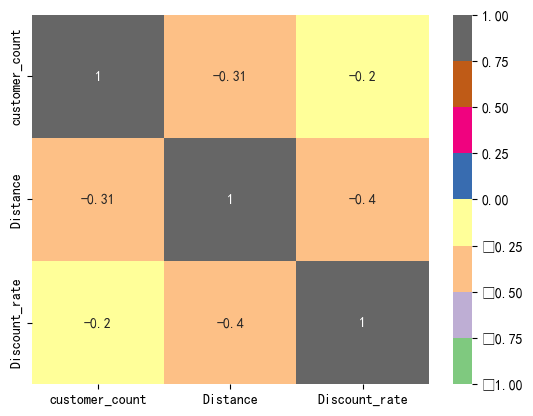

In [39]:
#用热力图展示相关系数
import seaborn as sns

sns.heatmap(data=merchant_pop_dis_rate.corr(), cmap='Accent', annot=True, vmax=1, vmin=-1)